<a href="https://colab.research.google.com/github/kili-technology/kili-python-sdk/blob/master/recipes/pixel_level_masks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing prediction labels

In this tutorial, we will show you how to import prediction labels into your Kili project.

We will discover this feature on a [segmentation project](https://docs.kili-technology.com/docs/semantic-segmentation) that aims at working with images or videos with pixel-level annotations.

The data used in this tutorial is from [COCO dataset](https://cocodataset.org).

## Import an image into your Kili project

Let's first inspect what our annotated image looks like in COCO dataset.


Raw image             |  With the annotations
:-------------------------:|:-------------------------:
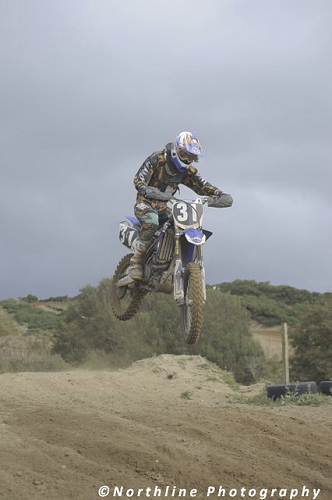 | 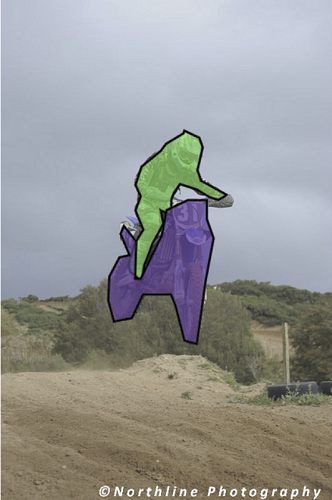!

You can go to [this URL](http://cocodataset.org/#explore?id=219921) to see all the annotations available.

Before starting, we install the requirements:

In [ ]:
!pip install matplotlib Pillow kili opencv-python

In [ ]:
%matplotlib inline

import functools
import time
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import getpass
import requests
from PIL import Image
from random import randint

# !apt install -y libgl1-mesa-glx  # TO DELETE
import cv2
from kili.client import Kili

Let's authenticate to Kili:

In [ ]:
if "KILI_API_KEY" not in os.environ:
    KILI_API_KEY = getpass.getpass("Please enter your API key: ")
else:
    KILI_API_KEY = os.environ["KILI_API_KEY"]

kili = Kili(api_key=KILI_API_KEY)

Let's create an image project in Kili where we can annotate images with a "semantic" tool and two classes: `HUMAN` and `MOTORCYCLE` at pixel level.

In [ ]:
json_interface = {
    "jobs": {
        "JOB_0": {
            "mlTask": "OBJECT_DETECTION",
            "tools": ["semantic"],
            "instruction": None,
            "required": 1,
            "isChild": False,
            "content": {
                "categories": {
                    "MOTORCYCLE": {"name": "Motorcycle", "children": [], "color": "#0755FF"},
                    "HUMAN": {"name": "Human", "children": [], "color": "#EEBA00"},
                },
                "input": "radio",
            },
        }
    }
}

In [ ]:
project = kili.create_project(
    description="COCO dataset",
    input_type="IMAGE",
    json_interface=json_interface,
    title="Motorcycle annotation",
)

project_id = project["id"]

In [ ]:
external_id = "moto"
content = "https://farm7.staticflickr.com/6153/6181981748_6a225c275d_z.jpg"

kili.append_many_to_dataset(
    project_id=project_id,
    content_array=[content],
    external_id_array=[external_id],
    json_content_array=None,
)

{'id': 'ckx4ex9he000wzwtl9sztcka6'}

Now you should be able to visualize your asset in Kili Technology:

<img src="./img/motorcycle_without_annotations.png">

## Import annotations from a mask

Now, imagine you already have annotations stored as a mask. You want to insert it in Kili Technology as a [prediction](https://docs.kili-technology.com/recipes/importing-labels-and-predictions). Here is the mask:

<img src="./img/HUMAN.mask.png">

We can begin by reading the image:

In [ ]:
content = "https://farm7.staticflickr.com/6153/6181981748_6a225c275d_z.jpg"

In [ ]:
output = "./recipes/output.png"
with open(output, "wb") as f:
    content = requests.get(content).content
    f.write(content)
time.sleep(1)
image = cv2.imread(output)
y, x, _ = image.shape
shape = (y, x)

These two functions will help us convert the mask:

In [ ]:
def cv_to_kili(polygons, shape, category_name):
    """
    Converts OpenCV polygons to Kili annotations (called JSON response)
    """
    y_max, x_max = shape
    xy_max = max(x_max, y_max)
    if xy_max == 0:
        raise Exception("input image has zero size")
    normalized_polygons = []
    for polygon in polygons:
        normalized_polygon = []
        for point in polygon:
            x = point[0][0]
            y = point[0][1]
            normalized_polygon.append({"x": x / x_max, "y": y / y_max})
        normalized_polygons.append(normalized_polygon)
    annotations = []
    for normalized_polygon in normalized_polygons:
        annotations.append(
            {
                "boundingPoly": [{"normalizedVertices": normalized_polygon}],
                "categories": [{"name": category_name, "confidence": 100}],
                "mid": randint(100, 1000),
                "score": None,
                "type": "polygon",
            }
        )
    return {"JOB_0": {"annotations": annotations}}


def create_polygons_from_mask(path):
    image = cv2.imread(path)
    grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, threshold = cv2.threshold(grey_image, 127, 255, 0)
    contours, _ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

In [ ]:
polygons = create_polygons_from_mask("./recipes/img/HUMAN.mask.png")
json_response = cv_to_kili(polygons, shape, "HUMAN")

kili.create_predictions(
    project_id=project_id,
    external_id_array=[external_id],
    json_response_array=[json_response],
    model_name="original_mask",
)

{'id': 'ckx4ex9he000wzwtl9sztcka6'}

That's it! Your mask was just converted to Kili Technology's standard format and uploaded as a prediction to the platform.

## Export the annotations as a mask

You may want to do some changes to the annotation and download them back as a mask.

<img src="./img/motorcycle_with_annotations.png">

Let's see how you can achieve this!

First we define a function to convert JSON responses from Kili Technology to readable polygons in OpenCV.

In [ ]:
def kili_to_cv(json_response, shape):
    """
    Converts Kili annotations (called JSON response) to OpenCV format
    """
    y, x = shape
    polygons = {}
    for job_name in json_response:
        job = json_response[job_name]
        if "annotations" not in job:
            continue
        annotations = job["annotations"]
        for annotation in annotations:
            categories = annotation["categories"]
            category = functools.reduce(lambda acc, cat: acc + cat["name"], categories, "")
            vertices = annotation["boundingPoly"][0]["normalizedVertices"]
            polygon = [[int(vertice["x"] * x), int(vertice["y"] * y)] for vertice in vertices]
            if category not in polygons:
                polygons[category] = [polygon]
            else:
                polygons[category].append(polygon)
    return polygons

Then, we can retrieve JSON responses, and print and save masks.

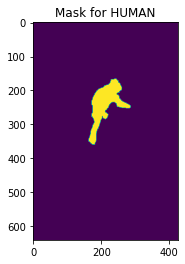

In [ ]:
labels = kili.labels(
    project_id=project_id, asset_external_id_in=[external_id], fields=["jsonResponse"]
)
json_response = labels[-1]["jsonResponse"]

polygons = kili_to_cv(json_response, shape)

for category in ["HUMAN", "MOTORCYCLE"]:
    mask = np.zeros(shape)
    if category not in polygons:
        continue
    cv2.fillPoly(mask, np.array(polygons[category], dtype=np.int32), 1)
    plt.figure()
    plt.title(f"Mask for {category}")
    plt.imshow(mask)
    mask_image = Image.fromarray(mask * 255).convert("L")
    mask_image.save(f"{category}.mask.png")